# Initialization

In [1]:
%%capture
!pip install geopandas

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import LongType, DecimalType, IntegerType, StructType, StructField, StringType, DoubleType
from pyspark.sql.functions import col, month, year, isnan, desc, unix_timestamp, to_timestamp, dayofmonth, hour, minute, second
from functools import reduce
import seaborn as sns
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

Matplotlib created a temporary cache directory at /scratch/hradhakrishnan/job_30614111/matplotlib-l0yzult8 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
# Setting up a theme with Seaborn
sns.set_theme(style="whitegrid")

# Adjusting font scale for better readability
sns.set_context("notebook", font_scale=1.2)

In [4]:
# Create a Spark session
# spark = SparkSession.builder \
#     .appName("Yellow Taxi EDA") \
#     .getOrCreate()


# I ran this notebook successfully using 4 cores and 8GB per node in the jupyter session setup. 
# Make sure you allocate enough memory per core. if you chose 3 cores you should select 6GB in your per Node setting.
spark = SparkSession.builder \
    .config("spark.driver.memory", "32g") \
	.config("spark.executor.memory", "4g") \
    .config('spark.executor.instances', 6) \
	.appName("Yellow Taxi EDA") \
	.getOrCreate()

In [5]:
spark

# Importing Data

In [6]:
base_path = 'yellow_taxi_data/yellow_tripdata_2023-{:02d}.parquet'

paths=[]
for mo in range(1, 8):  # This loops from 1 to 12
    path = base_path.format(mo)  # Formats the month with leading zero if necessary
    paths.append(path)

# paths = ['yellow_taxi_data/yellow_tripdata_2023-01.parquet', 'yellow_taxi_data/yellow_tripdata_2023-02.parquet']

In [7]:
# spark.read.parquet('yellow_taxi_data/yellow_tripdata_2023-01.parquet')

In [8]:
# Function to load and cast a single Parquet file
def load_and_cast(filepath):
    df = spark.read.parquet(filepath)
    df = df.withColumn("VendorID", col("VendorID").cast(IntegerType()))
    return df

# Load, cast, and accumulate all DataFrames
dataframes = [load_and_cast(path) for path in paths]
df = reduce(lambda df1, df2: df1.unionByName(df2), dataframes)

# Show the DataFrame
df.show(1)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2023-01-01 00:32:10|  2023-01-01 00:40:36|            1.0|         0.97|       1.0|                 N|         161|         141|           2|        9.3|  1.0|    0.5|       0.

In [9]:
df.count()

22400728

In [10]:
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)



# EDA 

In [11]:
# Summary statistics for numeric fields
numeric_cols = ['passenger_count', 'trip_distance', 'fare_amount', 'tip_amount', 'total_amount']
df.select(numeric_cols).describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+
|summary|   passenger_count|     trip_distance|       fare_amount|        tip_amount|      total_amount|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|          21787090|          22400728|          22400728|          22400728|          22400728|
|   mean|1.3680345562440877| 4.133649454606703|19.225625617168063|3.4923347794780653|28.114818738409053|
| stddev|0.8960931075122344|250.72897196654205| 83.87932165312908| 4.035971340106765| 85.02730323662489|
|    min|               0.0|               0.0|            -959.9|            -411.0|           -982.95|
|    max|               9.0|         342344.85|         386983.63|             984.3|         386987.63|
+-------+------------------+------------------+------------------+------------------+------------------+



In [12]:
# Dictionary to hold the column names and their corresponding counts of missing values
missing_counts = {}

# Calculate missing values for each column, taking data type into consideration
for col_name in df.columns:
    if df.schema[col_name].dataType == "DoubleType" or df.schema[col_name].dataType == "FloatType":
        missing_count = df.filter((col(col_name).isNull()) | (isnan(col_name))).count()
    else:
        missing_count = df.filter(col(col_name).isNull()).count()
    missing_counts[col_name] = missing_count

# Convert the dictionary to a Pandas DataFrame for displaying as a table
missing_counts_df = pd.DataFrame(list(missing_counts.items()), columns=['Column Name', 'Missing Values'])

# Display the DataFrame as a table
print(missing_counts_df)

              Column Name  Missing Values
0                VendorID               0
1    tpep_pickup_datetime               0
2   tpep_dropoff_datetime               0
3         passenger_count          613638
4           trip_distance               0
5              RatecodeID          613638
6      store_and_fwd_flag          613638
7            PULocationID               0
8            DOLocationID               0
9            payment_type               0
10            fare_amount               0
11                  extra               0
12                mta_tax               0
13             tip_amount               0
14           tolls_amount               0
15  improvement_surcharge               0
16           total_amount               0
17   congestion_surcharge          613638
18            airport_fee          613638


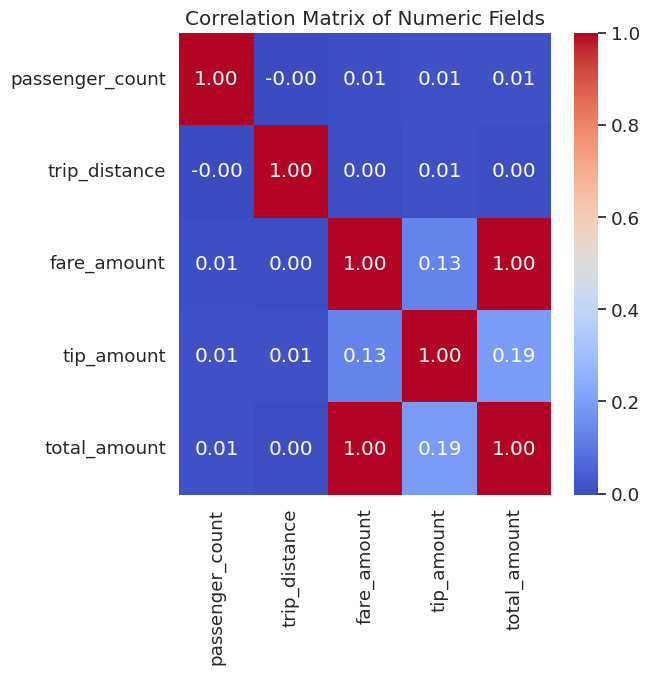

In [13]:
correlation_matrix = pd.DataFrame(index=numeric_cols, columns=numeric_cols)

for col1 in numeric_cols:
    for col2 in numeric_cols:
        corr_value = df.stat.corr(col1, col2)
        correlation_matrix.loc[col1, col2] = corr_value

# Convert entries from object to float for plotting
correlation_matrix = correlation_matrix.astype(float)

# Plotting the correlation matrix
plt.figure(figsize=(6, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Numeric Fields')
plt.show()

In [14]:
# Most common values for categorical fields
categorical_cols = ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type']
for col_name in categorical_cols:
    df.groupBy(col_name).count().orderBy(desc("count")).show()

+--------+--------+
|VendorID|   count|
+--------+--------+
|       2|16407737|
|       1| 5987171|
|       6|    5820|
+--------+--------+

+----------+--------+
|RatecodeID|   count|
+----------+--------+
|       1.0|20576693|
|       2.0|  869851|
|      NULL|  613638|
|       5.0|  114266|
|      99.0|  110397|
|       3.0|   74103|
|       4.0|   41744|
|       6.0|      36|
+----------+--------+

+------------------+--------+
|store_and_fwd_flag|   count|
+------------------+--------+
|                 N|21656738|
|              NULL|  613638|
|                 Y|  130352|
+------------------+--------+

+------------+-------+
|PULocationID|  count|
+------------+-------+
|         132|1169752|
|         237|1040446|
|         161|1030610|
|         236| 931863|
|         162| 788632|
|         186| 765281|
|         138| 756568|
|         230| 743546|
|         142| 735411|
|         170| 666073|
|         163| 647223|
|         239| 621931|
|          48| 606641|
|         234| 

In [15]:
def filter_quantile_range(df, col_names, lower_quantile=0.01, upper_quantile=0.99):
    """
    Filter data in the DataFrame based on the specified quantile range for given columns.

    Parameters:
        df (DataFrame): The input DataFrame to filter.
        col_names (list): List of column names to filter on.
        lower_quantile (float): The lower quantile bound (e.g., 0.1 for the 10th percentile).
        upper_quantile (float): The upper quantile bound (e.g., 0.9 for the 90th percentile).

    Returns:
        DataFrame: The filtered DataFrame within the specified quantile range.
    """
    # Initialize an empty list to store the filter conditions
    conditions = []
    
    for column_name in col_names:
        # Get the quantile bounds for the column
        lower_bound, upper_bound = df.approxQuantile(column_name, [lower_quantile, upper_quantile], 0.01)
        
        # Create a condition to filter data within the quantile range for this column
        condition = (col(column_name) >= lower_bound) & (col(column_name) <= upper_bound)
        conditions.append(condition)
    
    # Combine all the conditions using AND (every column must meet its own condition)
    combined_condition = conditions[0]
    for condition in conditions[1:]:
        combined_condition &= condition
    
    # Filter the DataFrame based on the combined condition
    filtered_df = df.filter(combined_condition)
    
    return filtered_df

In [16]:
# Sampling a fraction of the data for visualization
sampled_df = df.sample(fraction=0.1, withReplacement=False)

In [17]:
sampled_df.cache()

DataFrame[VendorID: int, tpep_pickup_datetime: timestamp_ntz, tpep_dropoff_datetime: timestamp_ntz, passenger_count: double, trip_distance: double, RatecodeID: double, store_and_fwd_flag: string, PULocationID: bigint, DOLocationID: bigint, payment_type: bigint, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improvement_surcharge: double, total_amount: double, congestion_surcharge: double, airport_fee: double]

## 1. Total Amount/ Fare Amount/ Tip Amount

In [18]:
pandas_df = sampled_df.select("total_amount", "tip_amount", "fare_amount").toPandas()

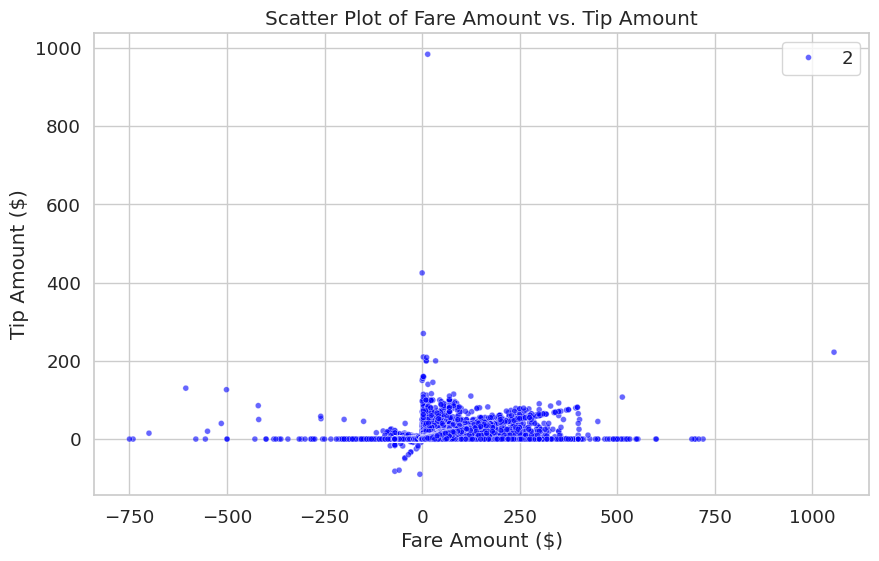

In [19]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='fare_amount', y='tip_amount', data=pandas_df, color='blue', size=2, alpha=0.6)
plt.title('Scatter Plot of Fare Amount vs. Tip Amount')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Tip Amount ($)')
plt.show()

### Analysis of negative fare and tip amounts

In [20]:
# Filter for negative fares and tips, group by payment type
negative_fares_tips = sampled_df.filter((col("fare_amount") < 0) | (col("tip_amount") < 0))

In [21]:
negative_fares_tips.groupBy("payment_type").count().show()

+------------+-----+
|payment_type|count|
+------------+-----+
|           0|  185|
|           1|   15|
|           3| 3000|
|           2| 3918|
|           4|10165|
+------------+-----+



In [22]:
# Group by RateCodeID for entries with negative fares or tips
negative_fares_tips.groupBy("RateCodeID").count().show()

+----------+-----+
|RateCodeID|count|
+----------+-----+
|      NULL|  185|
|       1.0|15385|
|       4.0|   63|
|       3.0|  185|
|       2.0| 1181|
|       5.0|  284|
+----------+-----+



In [23]:
# Extract year and month, then analyze counts of negative values
negative_fares_tips.withColumn("year", year("tpep_pickup_datetime")) \
    .withColumn("month", month("tpep_pickup_datetime")) \
    .groupBy("year", "month").count().orderBy("year", "month").show()

+----+-----+-----+
|year|month|count|
+----+-----+-----+
|2023|    1| 2442|
|2023|    2| 2502|
|2023|    3| 3003|
|2023|    4| 3017|
|2023|    5| 3170|
|2023|    6| 3149|
+----+-----+-----+



### Filter outliers based on quantiles

In [24]:
filtered_df = filter_quantile_range(sampled_df, ["total_amount", "tip_amount", "fare_amount"], lower_quantile=0.05, upper_quantile=0.95)

In [25]:
filtered_pandas_df = filtered_df.select("total_amount", "tip_amount", "fare_amount").toPandas()

In [26]:
filtered_pandas_df

total_amount  tip_amount  fare_amount
0               19.68        3.28        11.40
1               37.32        6.22        26.10
2               27.10        3.00        19.10
3               13.00        1.50         6.50
4               17.15        2.85         9.30
...               ...         ...          ...
1676796         45.67        0.00        41.67
1676797         33.10        3.01        26.09
1676798         53.48        5.77        37.16
1676799         35.96        0.00        31.96
1676800         51.04        8.51        38.53

[1676801 rows x 3 columns]

In [27]:
filtered_pandas_df.describe()

total_amount    tip_amount   fare_amount
count  1.676801e+06  1.676801e+06  1.676801e+06
mean   2.395075e+01  2.917261e+00  1.600465e+01
std    1.150930e+01  2.287025e+00  9.496193e+00
min    1.120000e+01  0.000000e+00  5.800000e+00
25%    1.630000e+01  1.000000e+00  9.300000e+00
50%    2.052000e+01  2.850000e+00  1.280000e+01
75%    2.760000e+01  4.060000e+00  1.910000e+01
max    8.120000e+01  1.121000e+01  6.460000e+01

/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


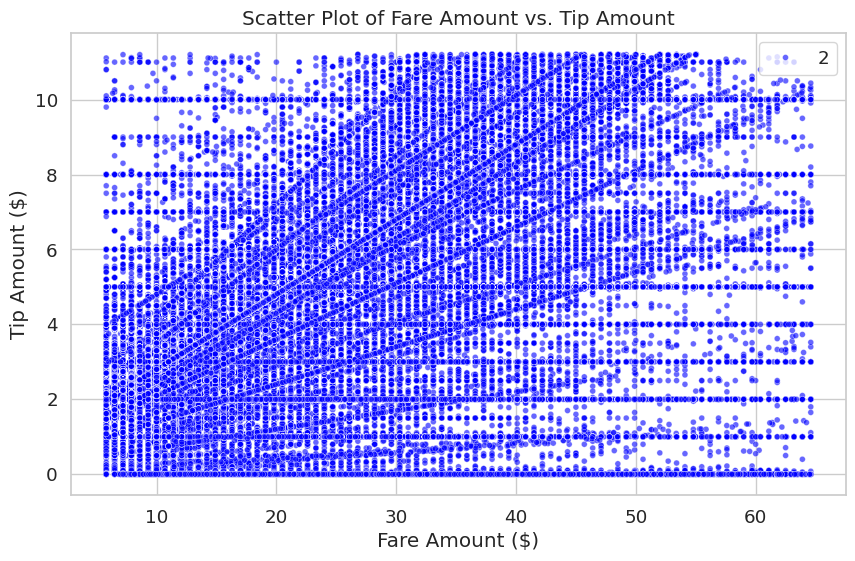

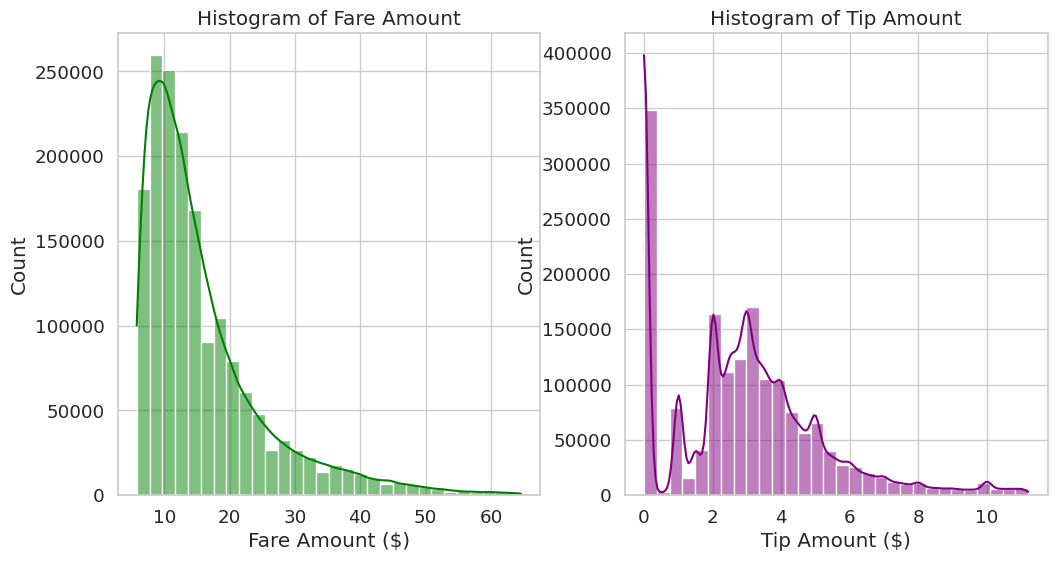

In [28]:
# Scatter plot to observe the relationship between fare amount and tip amount
plt.figure(figsize=(10, 6))
sns.scatterplot(x='fare_amount', y='tip_amount', data=filtered_pandas_df, color='blue', size=2, alpha=0.6)
plt.title('Scatter Plot of Fare Amount vs. Tip Amount')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Tip Amount ($)')
plt.show()

# Histograms to view the distributions of fare amount and tip amount
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(filtered_pandas_df['fare_amount'], kde=True, bins=30, color='green')
plt.title('Histogram of Fare Amount')
plt.xlabel('Fare Amount ($)')

plt.subplot(1, 2, 2)
sns.histplot(filtered_pandas_df['tip_amount'], kde=True, bins=30, color='purple')
plt.title('Histogram of Tip Amount')
plt.xlabel('Tip Amount ($)')
plt.show()

In [29]:
# if, even after filtering based on quantiles there are some negative fare/ tip amounts, we can filter those
# filtered_pandas_df = filtered_pandas_df[(pandas_df['fare_amount']>0) & (pandas_df['tip_amount']>0)]

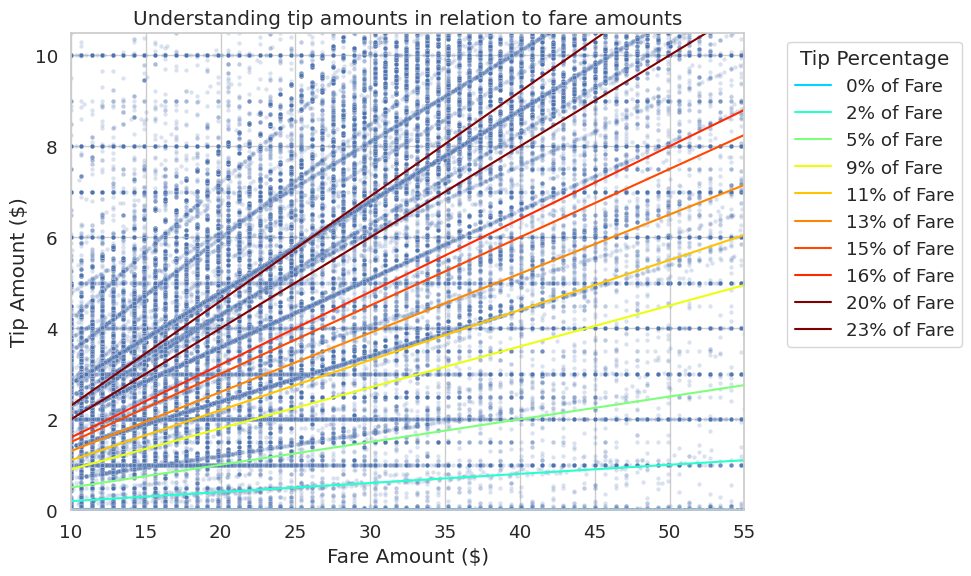

In [30]:
# Understanding tip amounts in relation to fare amounts
slopes = [0,2,5,9,11,13,15, 16,20, 23]
x_val = np.linspace(0, 60, 100)  

plt.figure(figsize=(10, 6))
sns.scatterplot(x='fare_amount', y='tip_amount', data=filtered_pandas_df, alpha=0.2, s=10)

for slope in slopes:
    y_values = slope * x_val * 0.01
    plt.plot(x_val, y_values, label=f'{slope}% of Fare', color=plt.cm.jet((slope+10) / 30)) 

plt.title("Understanding tip amounts in relation to fare amounts")
plt.xlabel('Fare Amount ($)')
plt.ylabel('Tip Amount ($)')
plt.legend(title='Tip Percentage', bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.ylim([0,10.5])
plt.xlim([10,55])
plt.tight_layout()
plt.show()

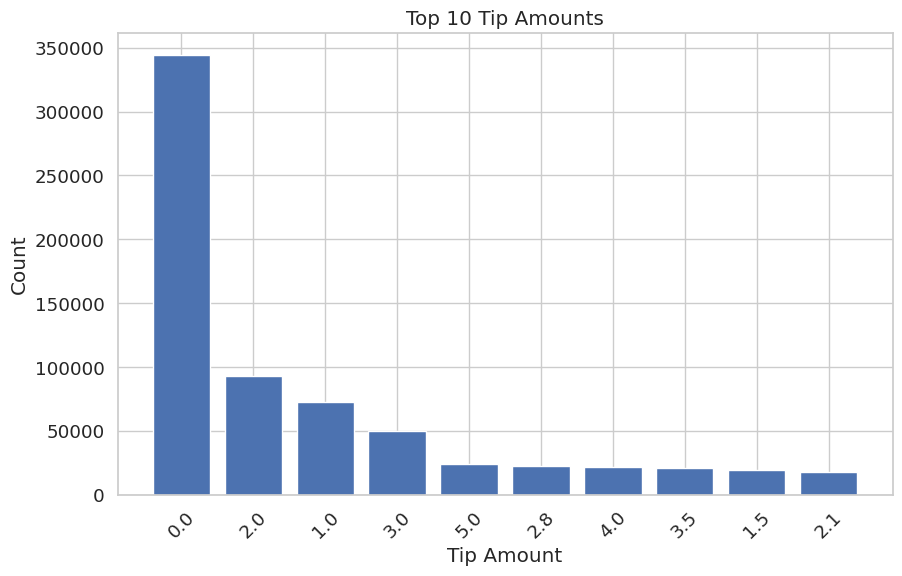

In [31]:
# Grouping by 'tip_amount' and counting occurrences
grouped_df = filtered_pandas_df.groupby('tip_amount').size().reset_index(name='count')

# Sorting by count in descending order and keeping the top 10
top_10 = grouped_df.sort_values(by='count', ascending=False).head(10)

# Plotting the top 10
plt.figure(figsize=(10, 6))
plt.bar(top_10['tip_amount'].astype(str), top_10['count'])
plt.xlabel('Tip Amount')
plt.ylabel('Count')
plt.title('Top 10 Tip Amounts')
plt.xticks(rotation=45)
plt.show()

In [32]:
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error

# # Prepare the data for linear regression
# X_fare = filtered_pandas_df[['fare_amount']]
# X_total = filtered_pandas_df[['total_amount']]
# y = filtered_pandas_df['tip_amount']

# # Initialize Linear Regression model
# model = LinearRegression()

# # Fit the model and predict for fare_amount
# model.fit(X_fare, y)
# y_pred_fare = model.predict(X_fare)
# mse_fare = mean_squared_error(y, y_pred_fare)

# # Fit the model and predict for total_amount
# model.fit(X_total, y)
# y_pred_total = model.predict(X_total)
# mse_total = mean_squared_error(y, y_pred_total)

# # Print the mean squared errors
# print(f'Mean Squared Error for Fare Amount vs Tip Amount: {mse_fare:.2f}')
# print(f'Mean Squared Error for Total Amount vs Tip Amount: {mse_total:.2f}')

In [33]:
# # Plot the correlation between fare_amount and tip_amount
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='fare_amount', y='tip_amount', data=filtered_pandas_df, alpha=0.5, label='Data')
# plt.plot(X_fare, y_pred_fare, color='red', label='Trend Line')
# plt.title('Fare Amount vs Tip Amount')
# plt.xlabel('Fare Amount')
# plt.ylabel('Tip Amount')
# plt.grid(True)
# plt.legend()
# plt.show()

# # Plot the correlation between total_amount and tip_amount
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='total_amount', y='tip_amount', data=filtered_pandas_df, alpha=0.5, label='Data')
# plt.plot(X_total, y_pred_total, color='red', label='Trend Line')
# plt.title('Total Amount vs Tip Amount')
# plt.xlabel('Total Amount')
# plt.ylabel('Tip Amount')
# plt.grid(True)
# plt.legend()
# plt.show()

## 2. Trip Duration vs. Distance

In [34]:
# Calculate the time difference in seconds using unix_timestamp
sampled_df = sampled_df.withColumn(
    "trip_duration_seconds",
    unix_timestamp(col("tpep_dropoff_datetime")) - unix_timestamp(col("tpep_pickup_datetime"))
)

# filter using quantile range function based on time_difference_seconds
filtered_df = filter_quantile_range(sampled_df, ["trip_duration_seconds", "trip_distance"], 0.05, 0.95)

In [35]:
pandas_df = filtered_df.select("trip_distance", "trip_duration_seconds").toPandas()

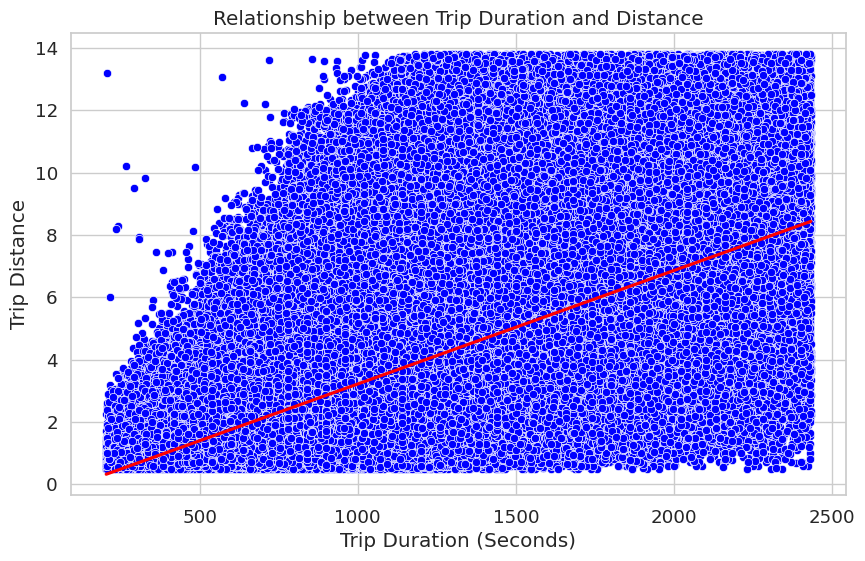

In [36]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='trip_duration_seconds', y='trip_distance', data=pandas_df, color='blue')
sns.regplot(x='trip_duration_seconds', y='trip_distance', data=pandas_df, scatter=False, color='red', ci=None)
plt.title("Relationship between Trip Duration and Distance")
plt.xlabel("Trip Duration (Seconds)")
plt.ylabel("Trip Distance")
plt.grid(True)
plt.show()


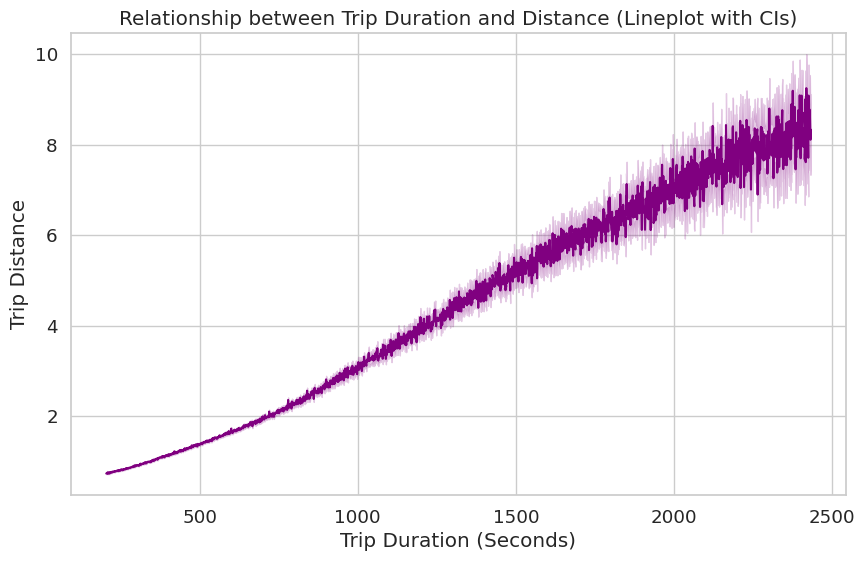

In [37]:
# As the trip duration increases, the trip distance also tends to increase.
plt.figure(figsize=(10, 6))
sns.lineplot(x='trip_duration_seconds', y='trip_distance', data=pandas_df, color='purple')
plt.title("Relationship between Trip Duration and Distance (Lineplot with CIs)")
plt.xlabel("Trip Duration (Seconds)")
plt.ylabel("Trip Distance")
plt.grid(True)
plt.show()

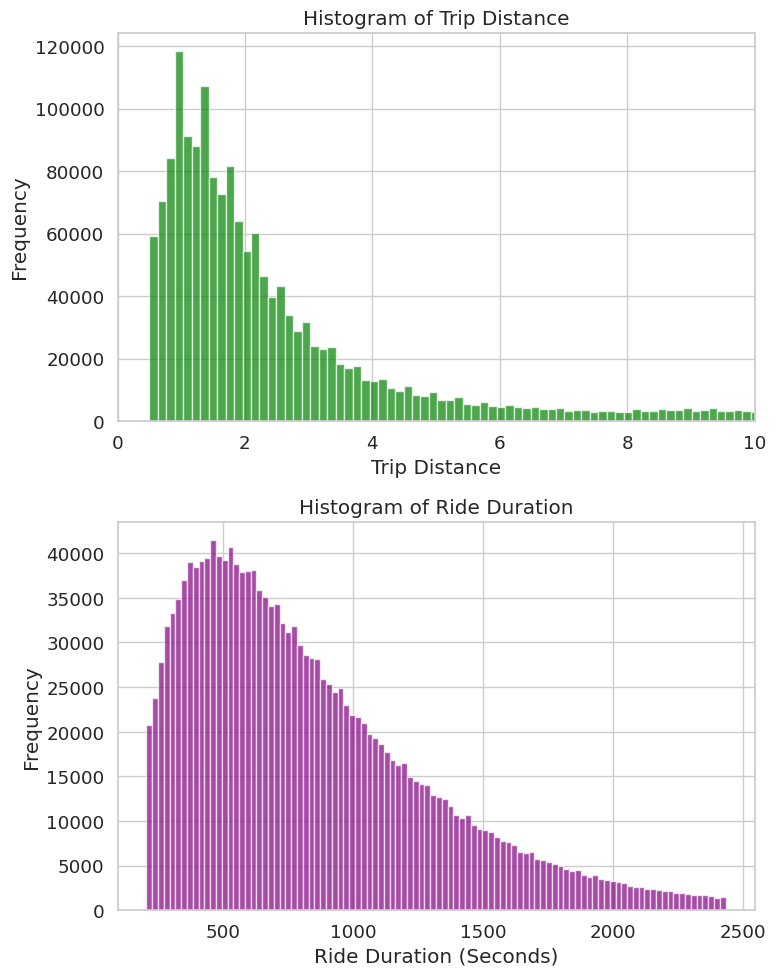

In [38]:
fig, axs = plt.subplots(2, 1, figsize=(8, 10))

# Histogram for trip distance
axs[0].hist(pandas_df["trip_distance"], bins=100,  color='green', alpha=0.7)
axs[0].set_title('Histogram of Trip Distance')
axs[0].set_xlabel('Trip Distance')
axs[0].set_ylabel('Frequency')
axs[0].set_xlim(0, 10)
axs[0].grid(True)

# Histogram for ride duration
axs[1].hist(pandas_df["trip_duration_seconds"], bins=100, color='purple', alpha=0.7)
axs[1].set_title('Histogram of Ride Duration')
axs[1].set_xlabel('Ride Duration (Seconds)')
axs[1].set_ylabel('Frequency')
axs[1].grid(True)

plt.tight_layout()
plt.show()

## 3. Trends by hour of day

In [39]:
sampled_df_time = sampled_df.withColumn("tpep_pickup_datetime", to_timestamp("tpep_pickup_datetime"))
sampled_df_time = sampled_df_time.withColumn("year", year("tpep_pickup_datetime")) \
       .withColumn("month", month("tpep_pickup_datetime")) \
       .withColumn("day", dayofmonth("tpep_pickup_datetime")) \
       .withColumn("hour", hour("tpep_pickup_datetime")) \
       .withColumn("minute", minute("tpep_pickup_datetime")) \
       .withColumn("second", second("tpep_pickup_datetime"))

# sampled_df_time.show()

In [40]:
pandas_time_df = sampled_df_time.select("year","month","day","hour","minute","second","Extra","fare_amount", "trip_distance").toPandas()
pandas_time_df['Amount_per_Distance'] = pandas_time_df["fare_amount"]/pandas_time_df["trip_distance"]
pandas_time_df

year  month  day  hour  minute  second  Extra  fare_amount  \
0        2023      1    1     0      53       1    1.0        11.40   
1        2023      1    1     0      34      44    1.0        26.10   
2        2023      1    1     0      23      52    1.0        19.10   
3        2023      1    1     0      56      44    3.5         6.50   
4        2023      1    1     0      27      27    3.5         9.30   
...       ...    ...  ...   ...     ...     ...    ...          ...   
1948123  2023      6   30    23       6      42    0.0        41.67   
1948124  2023      6   30    23      36      40    0.0        26.09   
1948125  2023      6   30    23       4      38    0.0        37.16   
1948126  2023      6   30    23      58       2    0.0        31.96   
1948127  2023      6   30    23      30      21    0.0        38.53   

         trip_distance  Amount_per_Distance  
0                 1.80             6.333333  
1                 3.23             8.080495  
2                 3.24             5.895062  
3                 0.40            16.250000  
4                 1.30             7.153846  
...                ...                  ...  
1948123          10.99             3.791629  
1948124           5.18             5.036680  
1948125          13.07             2.843152  
1948126           9.87             3.238095  
1948127           9.20             4.188043  

[1948128 rows x 10 columns]

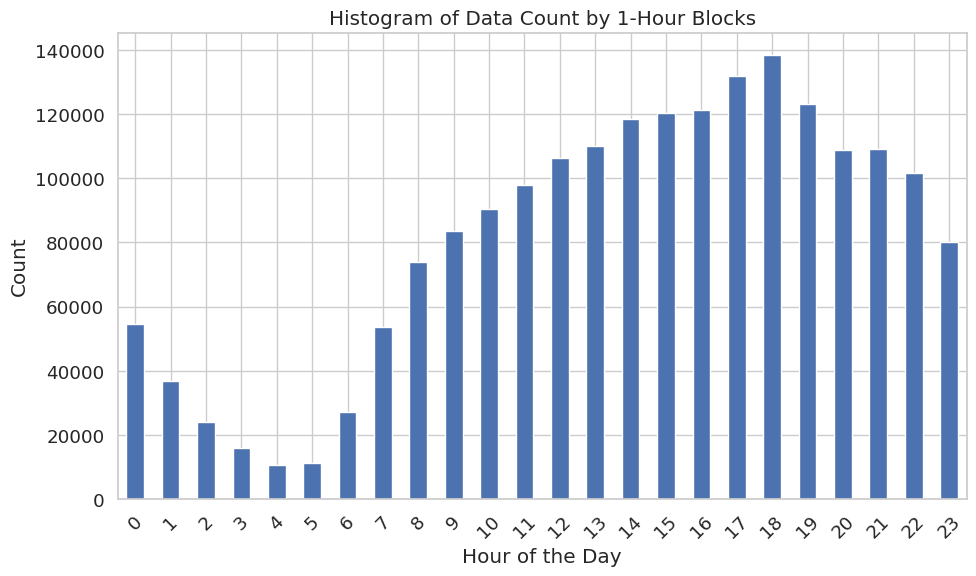

In [41]:
time_block_counts = pandas_time_df.groupby('hour').size()

plt.figure(figsize=(10, 6))
time_block_counts.plot(kind='bar')
plt.title('Histogram of Data Count by 1-Hour Blocks')
plt.xlabel('Hour of the Day')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

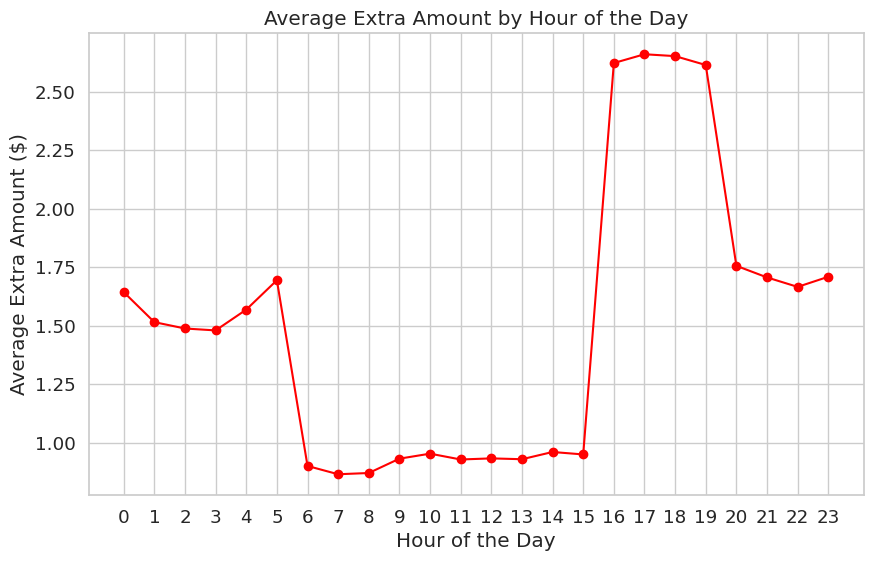

In [42]:
hourly_avg = pandas_time_df.groupby('hour')['Extra'].mean()

plt.figure(figsize=(10, 6))
plt.plot(hourly_avg.index, hourly_avg.values, marker='o', color='red')
plt.title('Average Extra Amount by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Extra Amount ($)')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

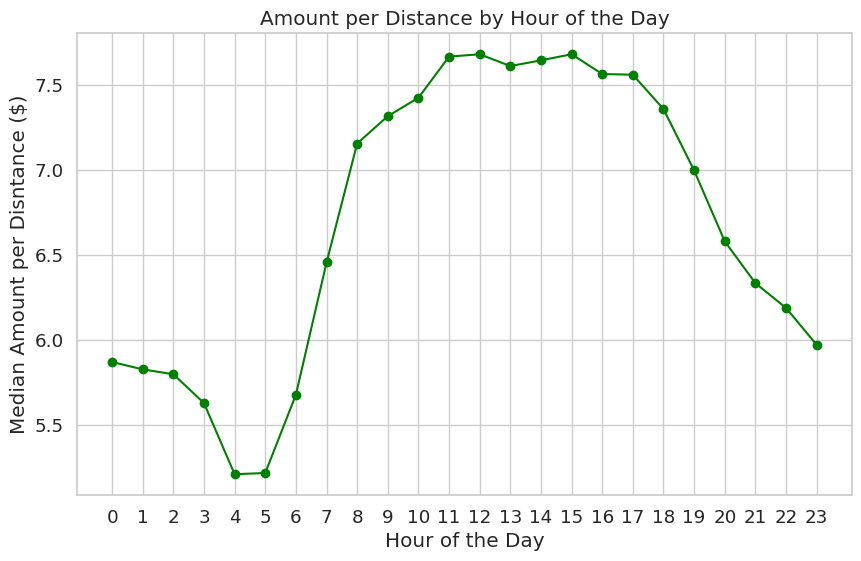

In [43]:
avg = pandas_time_df.groupby('hour')['Amount_per_Distance'].median()

plt.figure(figsize=(10, 6))
plt.plot(avg.index, avg.values, marker='o', color='green')
plt.title('Amount per Distance by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Median Amount per Disntance ($)')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

## 4. Distribution of Payment Type by Locations & Months

+------------+------------+------+
|PULocationID|payment_type| count|
+------------+------------+------+
|         236|           1|678126|
|         175|           2|    80|
|         255|           3|    66|
|         195|           4|    23|
|           3|           0|    10|
|         256|           4|   106|
|          95|           2|   556|
|         146|           0|   710|
|         212|           1|   341|
|          80|           3|    69|
|         256|           1|  3555|
|         136|           1|   680|
|         214|           3|     1|
|         253|           2|    16|
|         243|           4|    69|
|          44|           3|    11|
|          88|           0|  1870|
|         226|           2|  5006|
|          39|           3|    28|
|         139|           2|    34|
+------------+------------+------+
only showing top 20 rows

+------------+------------+------+
|DOLocationID|payment_type| count|
+------------+------------+------+
|         236|           1|72

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


ConnectionRefusedError: [Errno 111] Connection refused

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


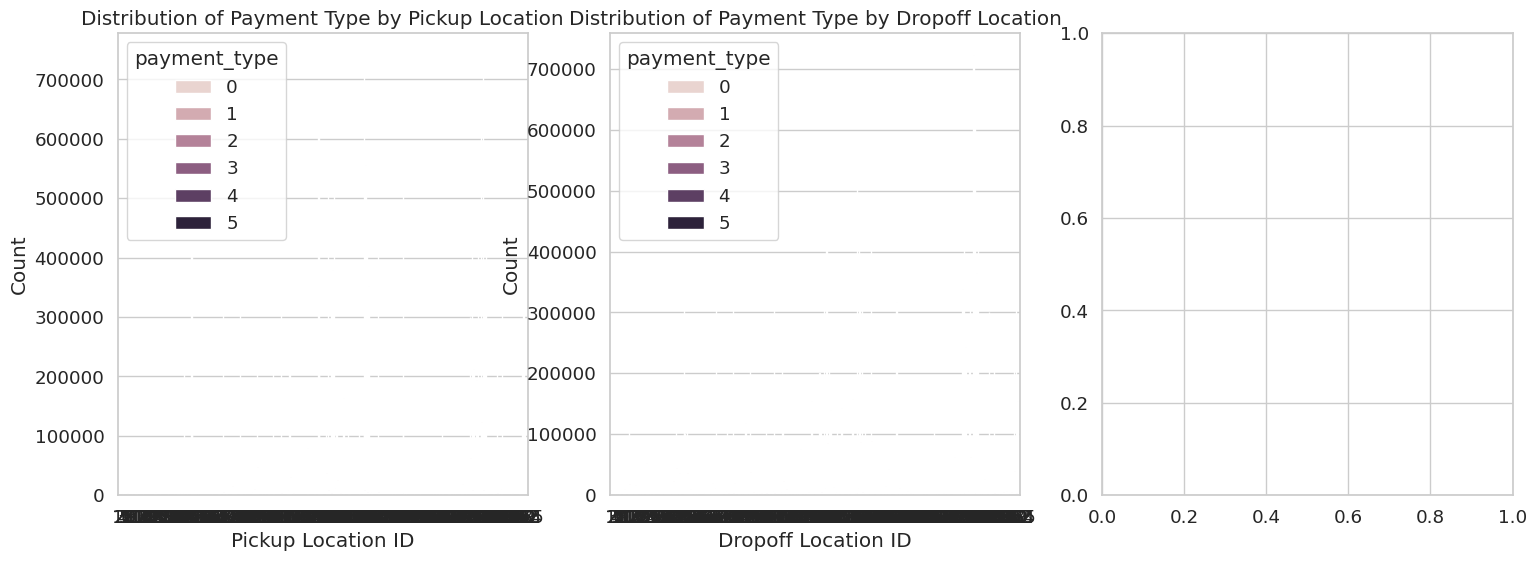

In [46]:
# Distribution of Payment_type by Pickup Location
pickup_location_distribution = df.groupBy("PULocationID", "payment_type").count()

# Distribution of Payment_type by Dropoff Location
dropoff_location_distribution = df.groupBy("DOLocationID", "payment_type").count()

# Distribution of Payment_type by Month
month_distribution = df.withColumn("month", month("tpep_pickup_datetime")) \
    .groupBy("month", "payment_type").count()

# Show the distributions
pickup_location_distribution.show()
dropoff_location_distribution.show()
month_distribution.show()

# Plotting the distributions
plt.figure(figsize=(18, 6))

# Distribution by Pickup Location
plt.subplot(1, 3, 1)
sns.barplot(x="PULocationID", y="count", hue="payment_type", data=pickup_location_distribution.toPandas())
plt.title('Distribution of Payment Type by Pickup Location')
plt.xlabel('Pickup Location ID')
plt.ylabel('Count')

# Distribution by Dropoff Location
plt.subplot(1, 3, 2)
sns.barplot(x="DOLocationID", y="count", hue="payment_type", data=dropoff_location_distribution.toPandas())
plt.title('Distribution of Payment Type by Dropoff Location')
plt.xlabel('Dropoff Location ID')
plt.ylabel('Count')

# Distribution by Month
plt.subplot(1, 3, 3)
sns.barplot(x="month", y="count", hue="payment_type", data=month_distribution.toPandas())
plt.title('Distribution of Payment Type by Month')
plt.xlabel('Month')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [ ]:
df.withColumn("month", month("tpep_pickup_datetime")) \
    .groupBy("month").count().show()

## 6. Visualizations on the map

## 6. Visualizations on the map

In [18]:
loc = pd.read_csv('yellow_taxi_data/taxi_zone_lookup.csv')

In [19]:
df

DataFrame[VendorID: int, tpep_pickup_datetime: timestamp_ntz, tpep_dropoff_datetime: timestamp_ntz, passenger_count: double, trip_distance: double, RatecodeID: double, store_and_fwd_flag: string, PULocationID: bigint, DOLocationID: bigint, payment_type: bigint, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improvement_surcharge: double, total_amount: double, congestion_surcharge: double, airport_fee: double]

In [20]:
pudf = df.select('PULocationID','DOLocationID').cache()

In [21]:
schema = StructType([
StructField("LocationID", StringType(), True),
StructField("Borough", StringType(), True),
StructField("Zone", StringType(), True),
StructField("service_zone", StringType(), True)])

locdf = spark.createDataFrame(loc, schema)

In [22]:
## Pickup Location

In [23]:
merged_doLoc = pudf.join(locdf, pudf.PULocationID == locdf.LocationID, how = 'left')
loc_grouped = merged_doLoc.groupBy(['service_zone','Borough','Zone']).count().orderBy('count', ascending = False).toPandas()
zone = gpd.read_file("yellow_taxi_data/taxi_zones/taxi_zones.shp")
map_df = zone.merge(loc_grouped, left_on = 'zone', right_on ='Zone' )
map_df['center'] = map_df.representative_point()

Text(113.00518163317493, 0.5, 'Latitude')

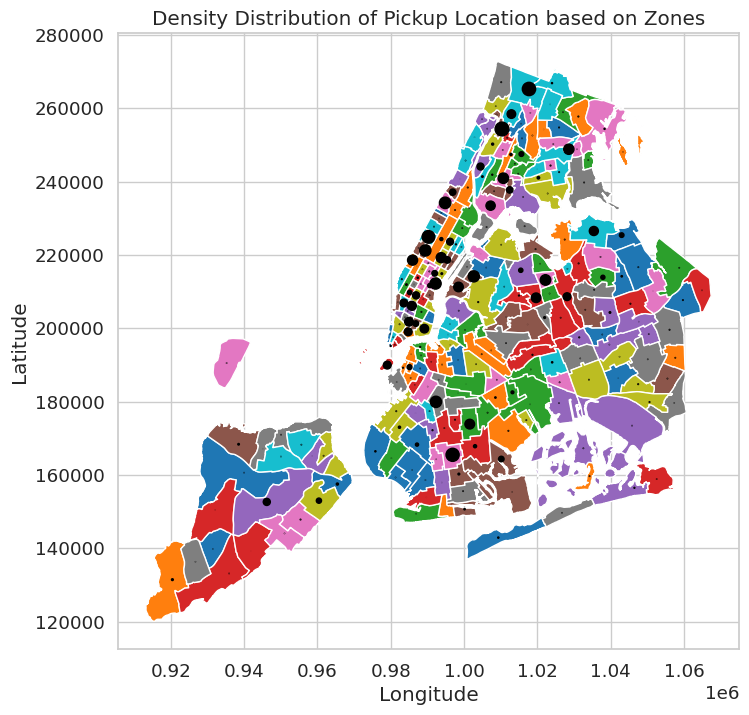

In [24]:
# Plotting the density of dropoff for each 'zone' 

map_df_dissolved_count = map_df.dissolve(by='zone', aggfunc={'count': 'sum'}).reset_index()
ax = map_df_dissolved_count.plot(figsize=(10, 8), column='zone', legend=False)

map_df_dissolved_count['center'] = map_df_dissolved_count.representative_point()
map_df_dissolved_count.rename(columns={'geometry': 'x1', 'center': 'geometry'})\
        .plot(ax=ax, marker='o', color='black', markersize=1*(map_df['count']/10000))

ax.set_title('Density Distribution of Pickup Location based on Zones')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

Text(113.00518163317493, 0.5, 'Latitude')

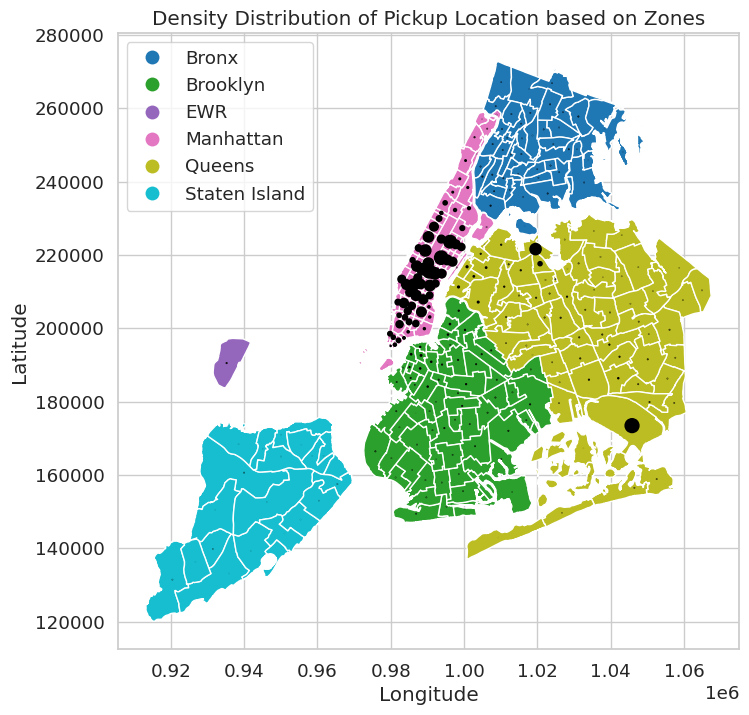

In [25]:
#choose either the above or below part
ny = zone.plot(column='borough', legend=True, figsize=(10, 8))
map_df.rename(columns = {'geometry': 'x1','center':'geometry'}).plot(ax=ny, marker='o', color='black', markersize = 1*(map_df['count']/10000))
ny.set_title('Density Distribution of Pickup Location based on Zones')
ny.set_xlabel('Longitude')
ny.set_ylabel('Latitude')


Text(113.00518163317493, 0.5, 'Latitude')

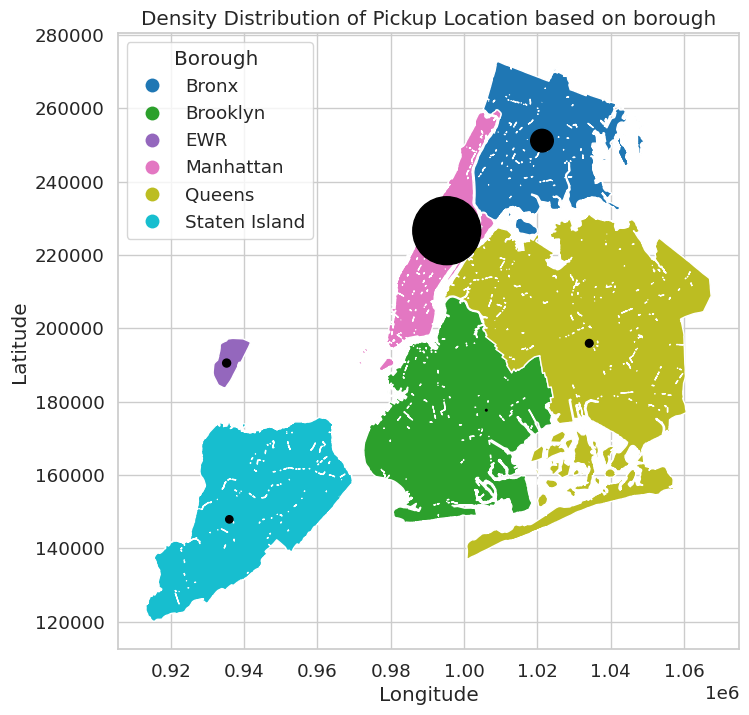

In [26]:
# Plotting the density of dropoff location for each 'borough' 
# Airports and Yellow Zone have the highest booking; Boro Zone and EWR contribution to pickup location are negligible
map_df_dissolved_count = map_df.dissolve(by='borough', aggfunc={'count': 'sum'}).reset_index()
ax = map_df_dissolved_count.plot(figsize=(10, 8), column='borough', legend=True, legend_kwds={'title': 'Borough ', 'loc': 'upper left'})
map_df_dissolved_count['center'] = map_df_dissolved_count.representative_point()
map_df_dissolved_count.rename(columns = {'geometry': 'x1','center':'geometry'}).plot(ax=ax, marker='o', color='black', markersize = 1*(map_df['count']/10))
ax.set_title('Density Distribution of Pickup Location based on borough')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


Text(113.00518163317493, 0.5, 'Latitude')

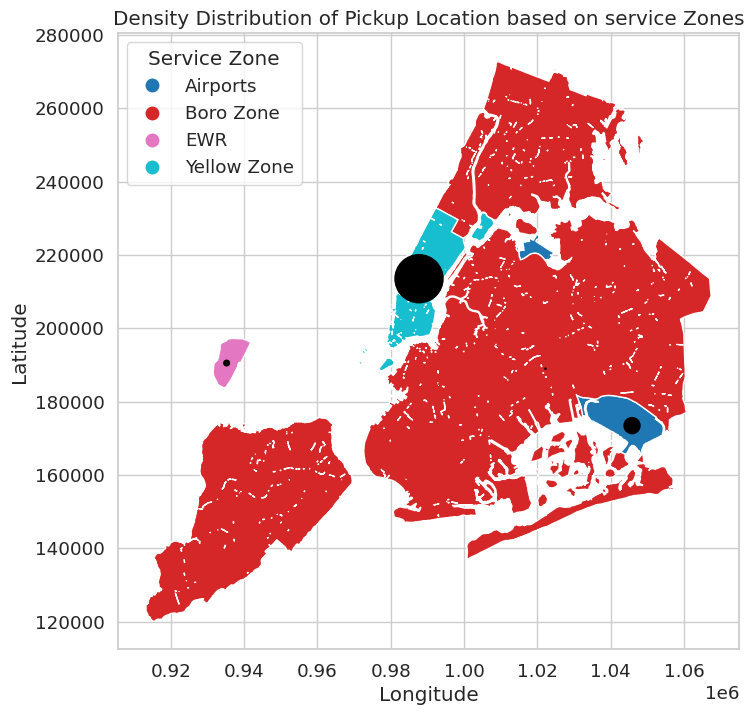

In [27]:
# Plotting the density of dropoff location for each 'service_zone' 
# Airports and Yellow Zone have the highest booking; Boro Zone and EWR contribution to pickup location are negligible
map_df_dissolved_count = map_df.dissolve(by='service_zone', aggfunc={'count': 'sum'}).reset_index()
ax = map_df_dissolved_count.plot(figsize=(10, 8), column='service_zone', legend=True, legend_kwds={'title': 'Service Zone', 'loc': 'upper left'})
map_df_dissolved_count['center'] = map_df_dissolved_count.representative_point()
map_df_dissolved_count.rename(columns = {'geometry': 'x1','center':'geometry'}).plot(ax=ax, marker='o', color='black', markersize = 1*(map_df['count']/20))
ax.set_title('Density Distribution of Pickup Location based on service Zones')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


In [41]:
zone

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0           1    0.116357    0.000782           Newark Airport           1   
1           2    0.433470    0.004866              Jamaica Bay           2   
2           3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3           4    0.043567    0.000112            Alphabet City           4   
4           5    0.092146    0.000498            Arden Heights           5   
..        ...         ...         ...                      ...         ...   
258       259    0.126750    0.000395       Woodlawn/Wakefield         259   
259       260    0.133514    0.000422                 Woodside         260   
260       261    0.027120    0.000034       World Trade Center         261   
261       262    0.049064    0.000122           Yorkville East         262   
262       263    0.037017    0.000066           Yorkville West         263   

           borough                                           geometry  
0              EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1           Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2            Bronx  POLYGON ((1026308.770 256767.698, 1026495.593 ...  
3        Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4    Staten Island  POLYGON ((935843.310 144283.336, 936046.565 14...  
..             ...                                                ...  
258          Bronx  POLYGON ((1025414.782 270986.139, 1025138.624 ...  
259         Queens  POLYGON ((1011466.966 216463.005, 1011545.889 ...  
260      Manhattan  POLYGON ((980555.204 196138.486, 980570.792 19...  
261      Manhattan  MULTIPOLYGON (((999804.795 224498.527, 999824....  
262      Manhattan  POLYGON ((997493.323 220912.386, 997355.264 22...  

[263 rows x 7 columns]

# Dropoff Location

In [28]:
merged_doLoc = pudf.join(locdf, pudf.DOLocationID == locdf.LocationID, how = 'left')
loc_grouped = merged_doLoc.groupBy(['service_zone','Borough','Zone']).count().orderBy('count', ascending = False).toPandas()
zone = gpd.read_file("yellow_taxi_data/taxi_zones/taxi_zones.shp")
map_df = zone.merge(loc_grouped, left_on = 'zone', right_on ='Zone' )
map_df['center'] = map_df.representative_point()

Text(113.00518163317493, 0.5, 'Latitude')

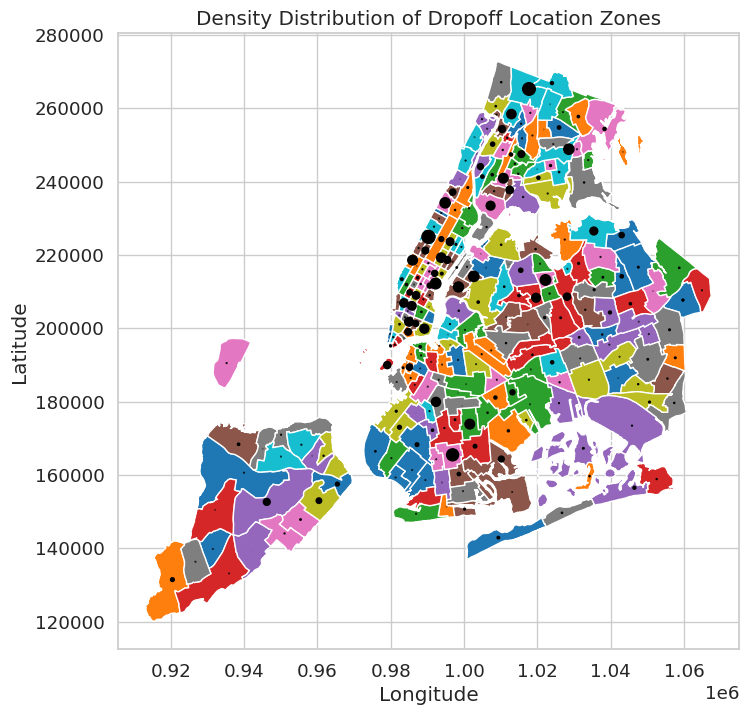

In [29]:
# Plotting the density of dropoff for each 'zone' 

map_df_dissolved_count = map_df.dissolve(by='zone', aggfunc={'count': 'sum'}).reset_index()
ax = map_df_dissolved_count.plot(figsize=(10, 8), column='zone', legend=False)

map_df_dissolved_count['center'] = map_df_dissolved_count.representative_point()
map_df_dissolved_count.rename(columns={'geometry': 'x1', 'center': 'geometry'})\
        .plot(ax=ax, marker='o', color='black', markersize=1*(map_df['count']/10000))

ax.set_title('Density Distribution of Dropoff Location Zones')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


Text(113.00518163317493, 0.5, 'Latitude')

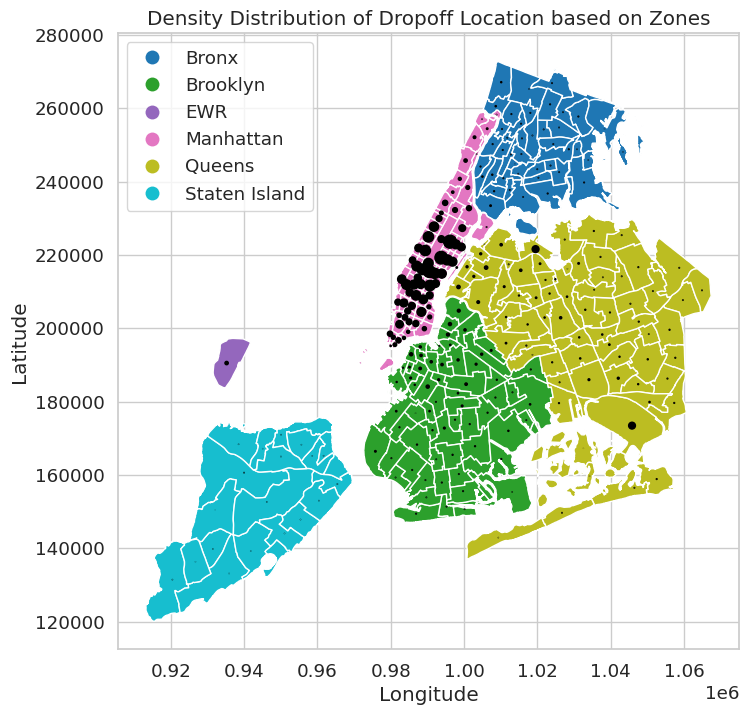

In [30]:
#choose either the above or below part
ny = zone.plot(column='borough', legend=True, figsize=(10, 8))
map_df.rename(columns = {'geometry': 'x1','center':'geometry'}).plot(ax=ny, marker='o', color='black', markersize = 1*(map_df['count']/10000))
ny.set_title('Density Distribution of Dropoff Location based on Zones')
ny.set_xlabel('Longitude')
ny.set_ylabel('Latitude')

Text(113.00518163317493, 0.5, 'Latitude')

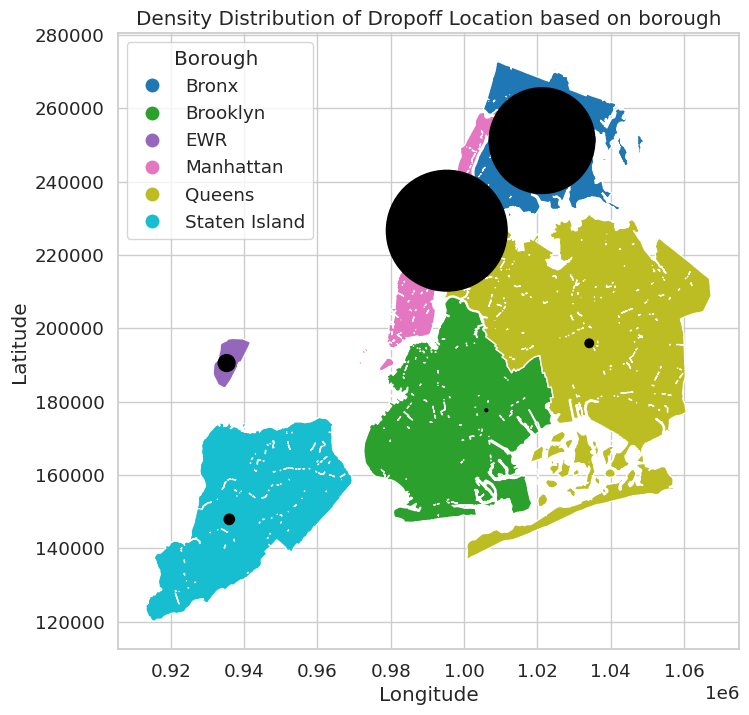

In [31]:
# Plotting the density of dropoff location for each 'borough' 

#compared to the pickup location density, we can see that bronx brough has a lot more pickups. 

map_df_dissolved_count = map_df.dissolve(by='borough', aggfunc={'count': 'sum'}).reset_index()
ax = map_df_dissolved_count.plot(figsize=(10, 8), column='borough', legend=True, legend_kwds={'title': 'Borough ', 'loc': 'upper left'})
map_df_dissolved_count['center'] = map_df_dissolved_count.representative_point()
map_df_dissolved_count.rename(columns = {'geometry': 'x1','center':'geometry'}).plot(ax=ax, marker='o', color='black', markersize = 1*(map_df['count']/10))
ax.set_title('Density Distribution of Dropoff Location based on borough')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

Text(113.00518163317493, 0.5, 'Latitude')

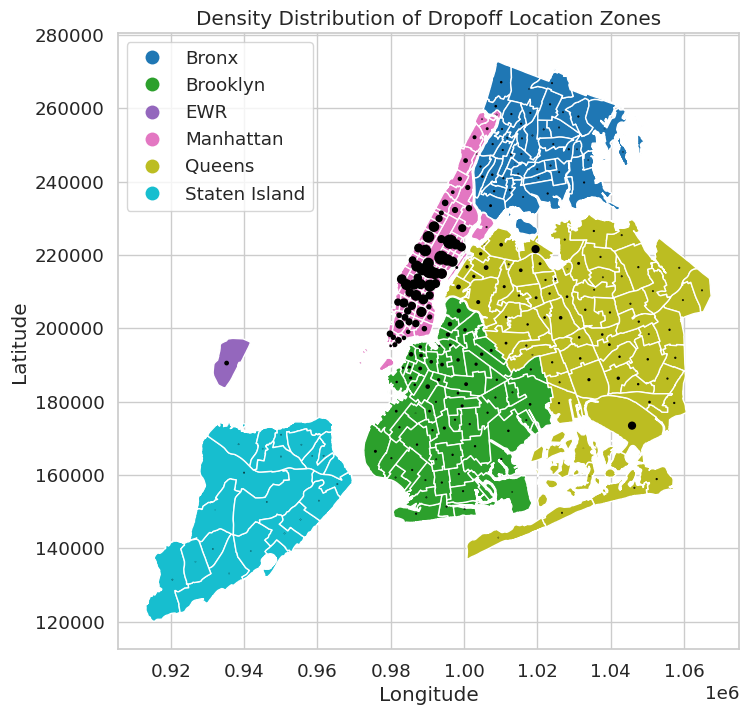

In [32]:
#choose either the above or below part
ny = zone.plot(column='borough', legend=True, figsize=(10, 8))
map_df.rename(columns = {'geometry': 'x1','center':'geometry'}).plot(ax=ny, marker='o', color='black', markersize = 1*(map_df['count']/10000))
ny.set_title('Density Distribution of Dropoff Location Zones')
ny.set_xlabel('Longitude')
ny.set_ylabel('Latitude')

# Model

In [39]:
from shapely.geometry import Point

In [40]:
zone = gpd.read_file("yellow_taxi_data/taxi_zones/taxi_zones.shp")

zone.set_crs("EPSG:2263", inplace=True)
zone['center'] = zone.representative_point()
center_gdf = gpd.GeoDataFrame(zone, geometry=zone['center'])
center_gdf = center_gdf.to_crs("EPSG:4326")

zone['long'] = center_gdf.geometry.x
zone['lat'] = center_gdf.geometry.y

zone = zone.drop(columns = ['OBJECTID','geometry','center'])

In [41]:
zone

Shape_Leng  Shape_Area                     zone  LocationID  \
0      0.116357    0.000782           Newark Airport           1   
1      0.433470    0.004866              Jamaica Bay           2   
2      0.084341    0.000314  Allerton/Pelham Gardens           3   
3      0.043567    0.000112            Alphabet City           4   
4      0.092146    0.000498            Arden Heights           5   
..          ...         ...                      ...         ...   
258    0.126750    0.000395       Woodlawn/Wakefield         259   
259    0.133514    0.000422                 Woodside         260   
260    0.027120    0.000034       World Trade Center         261   
261    0.049064    0.000122           Yorkville East         262   
262    0.037017    0.000066           Yorkville West         263   

           borough       long        lat  
0              EWR -74.176786  40.689516  
1           Queens -73.826126  40.625724  
2            Bronx -73.849479  40.865888  
3        Manhattan -73.977023  40.724152  
4    Staten Island -74.189930  40.550340  
..             ...        ...        ...  
258          Bronx -73.856351  40.899103  
259         Queens -73.903713  40.746798  
260      Manhattan -74.012919  40.708976  
261      Manhattan -73.945830  40.776534  
262      Manhattan -73.951208  40.778496  

[263 rows x 7 columns]

In [42]:
schemazone = StructType([
    StructField("Shape_Leng", DoubleType(), True),
    StructField("Shape_Area", DoubleType(), True),
    StructField("Zone", StringType(), True),
    StructField("LocationID", StringType(), True),
    StructField("Borough", StringType(), True),
    StructField("Long", DoubleType(), True),
    StructField("Lat", DoubleType(), True)

])

zonedf = spark.createDataFrame(zone, schemazone)

In [43]:
zonedf.show()

+---------------+----------------+--------------------+----------+-------------+------------------+------------------+
|     Shape_Leng|      Shape_Area|                Zone|LocationID|      Borough|              Long|               Lat|
+---------------+----------------+--------------------+----------+-------------+------------------+------------------+
| 0.116357453189|  7.823067885E-4|      Newark Airport|         1|          EWR|-74.17678574521403| 40.68951564804293|
|  0.43346966679|0.00486634037837|         Jamaica Bay|         2|       Queens|-73.82612577032016|  40.6257242377496|
|0.0843411059012|3.14414156821E-4|Allerton/Pelham G...|         3|        Bronx|-73.84947892385894| 40.86588754197535|
|0.0435665270921|1.11871946192E-4|       Alphabet City|         4|    Manhattan|-73.97702292193343|  40.7241521436721|
|0.0921464898574|4.97957489363E-4|       Arden Heights|         5|Staten Island|-74.18992967123748| 40.55034012383312|
| 0.150490542523|6.06460984581E-4|Arrochar/Fort 

In [44]:
merged_zone = df.join(zonedf, df.DOLocationID == zonedf.LocationID, how = 'left')

In [45]:
merged_zone = merged_zone.drop(*('VendorID','passenger_count','RatecodeID','store_and_fwd_flag','payment_type', 'fare_amount',
                                'extra','mta_tax','tip_amount','tolls_amount','improvement_surcharge','total_amount','congestion_surcharge',
                                'airport_fee', 'LocationID'))

In [46]:
merged_zone = merged_zone.withColumnRenamed("Shape_Leng", "PU_Shape_Leng") \
                         .withColumnRenamed("Shape_Area", "PU_Shape_Area") \
                         .withColumnRenamed("Zone", "PU_Zone") \
                         .withColumnRenamed("Borough", "PU_Borough") \
                         .withColumnRenamed("long", "PU_Long") \
                         .withColumnRenamed("lat", "PU_Lat")

In [47]:
merged_zone = merged_zone.join(zonedf, merged_zone.DOLocationID == zonedf.LocationID, how = 'left')

In [48]:
merged_zone = merged_zone.withColumnRenamed("Shape_Leng", "DO_Shape_Leng") \
                         .withColumnRenamed("Shape_Area", "DO_Shape_Area") \
                         .withColumnRenamed("Zone", "DO_Zone") \
                         .withColumnRenamed("Borough", "DO_Borough") \
                         .withColumnRenamed("long", "DO_Long") \
                         .withColumnRenamed("lat", "DO_Lat")

In [49]:
merged_zone.show(5)

+--------------------+---------------------+-------------+------------+------------+---------------+----------------+--------------------+----------+------------------+------------------+---------------+----------------+--------------------+----------+----------+------------------+------------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|trip_distance|PULocationID|DOLocationID|  PU_Shape_Leng|   PU_Shape_Area|             PU_Zone|PU_Borough|           PU_Long|            PU_Lat|  DO_Shape_Leng|   DO_Shape_Area|             DO_Zone|LocationID|DO_Borough|           DO_Long|            DO_Lat|
+--------------------+---------------------+-------------+------------+------------+---------------+----------------+--------------------+----------+------------------+------------------+---------------+----------------+--------------------+----------+----------+------------------+------------------+
| 2023-01-01 00:03:48|  2023-01-01 00:13:25|          1.9|         138|           7| 0.1074171

In [50]:
from pyspark.sql.functions import col, unix_timestamp, expr

merged_zone = merged_zone.withColumn('tpep_pickup_datetime', col('tpep_pickup_datetime').cast('timestamp'))
merged_zone = merged_zone.withColumn('tpep_dropoff_datetime', col('tpep_dropoff_datetime').cast('timestamp'))
merged_zone = merged_zone.withColumn('time_diff_seconds', unix_timestamp('tpep_dropoff_datetime') - unix_timestamp('tpep_pickup_datetime'))

merged_zone = merged_zone.withColumn('duration_mins', (col('time_diff_seconds') / 60).cast('int'))
merged_zone = merged_zone.drop('time_diff_seconds')

In [ ]:
merged_zone = merged_zone.drop('time_diff_seconds')

In [51]:
# merged_zone.show(5)


In [52]:
from pyspark.sql.functions import year, month, dayofmonth, hour, minute, dayofweek

merged_zone = merged_zone.withColumn('month', month('tpep_pickup_datetime')) \
                         .withColumn('day', dayofmonth('tpep_pickup_datetime')) \
                         .withColumn('hour', hour('tpep_pickup_datetime')) \
                         .withColumn('minute', minute('tpep_pickup_datetime'))\
                         .withColumn('dayOfWeek', dayofweek('tpep_pickup_datetime'))

In [53]:
# %%capture
# !pip install --upgrade holidays
# import holidays

# us_holidays = holidays.US()

In [33]:
# def is_holiday(date):
#     return date in holidays_broadcast.value

# from pyspark.sql.functions import udf
# from pyspark.sql.types import BooleanType

# is_holiday_udf = udf(is_holiday, BooleanType())


In [54]:
merged_zone = merged_zone.withColumn('is_weekend', (merged_zone.dayOfWeek.isin([1, 7])).cast('boolean'))
                            # .withColumn('is_holiday', is_holiday_udf(col('tpep_pickup_datetime').cast('date')))

In [55]:
merged_zone.show(2)

+--------------------+---------------------+-------------+------------+------------+---------------+----------------+--------------+----------+------------------+-----------------+---------------+----------------+--------------+----------+----------+------------------+-----------------+-------------+-----+---+----+------+---------+----------+
|tpep_pickup_datetime|tpep_dropoff_datetime|trip_distance|PULocationID|DOLocationID|  PU_Shape_Leng|   PU_Shape_Area|       PU_Zone|PU_Borough|           PU_Long|           PU_Lat|  DO_Shape_Leng|   DO_Shape_Area|       DO_Zone|LocationID|DO_Borough|           DO_Long|           DO_Lat|duration_mins|month|day|hour|minute|dayOfWeek|is_weekend|
+--------------------+---------------------+-------------+------------+------------+---------------+----------------+--------------+----------+------------------+-----------------+---------------+----------------+--------------+----------+----------+------------------+-----------------+-------------+-----+---

In [ ]:
.withColumn('isWeekend', dayofweek('tpep_pickup_datetime')

In [84]:
from pyspark.sql.functions import dayofweek, col, lit, when
from datetime import datetime

# Sample list of holidays
holidays = [
    '2024-01-01', '2024-07-04', '2024-12-25'  # Add more holiday dates as needed
]

# Convert holidays to a broadcast variable
holidays = [datetime.strptime(date, '%Y-%m-%d').date() for date in holidays]
holidays_broadcast = spark.sparkContext.broadcast(holidays)

# Function to check if a date is a holiday
def is_holiday(date):
    return date in holidays_broadcast.value

# Register the function as a UDF
from pyspark.sql.functions import udf
from pyspark.sql.types import BooleanType

is_holiday_udf = udf(is_holiday, BooleanType())

# Add 'is_weekend' and 'is_holiday' columns
merged_zone = merged_zone.withColumn('is_weekend', (dayofweek('tpep_pickup_datetime').isin([1, 7])).cast('boolean'))
merged_zone = merged_zone.withColumn('is_holiday', is_holiday_udf(col('tpep_pickup_datetime').cast('date')))

# Show the resulting DataFrame with the new columns
merged_zone.show()


+--------------------+---------------------+-------------+------------+------------+---------------+----------------+--------------+----------+------------------+-----------------+---------------+----------------+--------------+----------+----------+------------------+-----------------+-------------+-----+---+----+------+
|tpep_pickup_datetime|tpep_dropoff_datetime|trip_distance|PULocationID|DOLocationID|  PU_Shape_Leng|   PU_Shape_Area|       PU_Zone|PU_Borough|           PU_Long|           PU_Lat|  DO_Shape_Leng|   DO_Shape_Area|       DO_Zone|LocationID|DO_Borough|           DO_Long|           DO_Lat|duration_mins|month|day|hour|minute|
+--------------------+---------------------+-------------+------------+------------+---------------+----------------+--------------+----------+------------------+-----------------+---------------+----------------+--------------+----------+----------+------------------+-----------------+-------------+-----+---+----+------+
| 2023-01-01 00:57:29|  2023

In [87]:
!pip install --upgrade holidays
import holidays

us_holidays = holidays.US()

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 80.3 MB/s eta 0:00:00


In [93]:
'2025-01-01' in us_holidays

True